In [95]:
import text_transformer as tt
remove_tokens = ["’", "‘", "would", "said", "also", "“", "”", "–"]
filter_words = ["Trump"]
%time articles, _ = tt.preprocessing(directory="articles", verbose= True, remove_words=remove_tokens, filter_words=filter_words)


We're at 0.0% of the data.
We're at 6.12% of the data.
We're at 12.25% of the data.
We're at 18.37% of the data.
We're at 24.49% of the data.
We're at 30.62% of the data.
We're at 36.74% of the data.
We're at 42.86% of the data.
We're at 48.99% of the data.
We're at 55.11% of the data.
We're at 61.23% of the data.
We're at 67.36% of the data.
We're at 73.48% of the data.
We're at 79.6% of the data.
We're at 85.73% of the data.
We're at 91.85% of the data.
We're at 97.97% of the data.
Articles used: 14.52 %
Articles used: 2372/16331
*********************************************
2233  ( 13.67 %) Articles were filtered out because of length and
11726  ( 71.8 %) Articles were filtered out because of the filter words.
CPU times: user 3min 6s, sys: 50.7 s, total: 3min 57s
Wall time: 4min 2s


In [96]:
newspapers = set([article["newspaper"] for article in articles])
newspapers

{'aljazeera',
 'breitbart',
 'cbc',
 'dailymail',
 'euronews',
 'foxnews',
 'ft',
 'go',
 'huffpost',
 'latimes',
 'nbcnews',
 'nytimes',
 'reuters',
 'theguardian',
 'thetimes',
 'wsj',
 'yahoo'}

In [97]:
!pip install nltk
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
sia.polarity_scores(articles[0]["text"])

You are using pip version 9.0.3, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


{'neg': 0.086, 'neu': 0.807, 'pos': 0.107, 'compound': 0.9394}

In [98]:
import pandas as pd

articles_df = pd.DataFrame.from_dict(articles)

In [99]:
articles_df.head()

,author,newspaper,text,title,url
0,[Andrew Buncombe],yahoo,So we now know what Donald Trump’s 2020 re-ele...,Mueller's report is a massive win for Trump an...,https://news.yahoo.com/mueller-apos-report-mas...
1,[Kadia Tubman],yahoo,Special Counsel Robert Mueller’s investigation...,Trump takes victory lap as Mueller conclusions...,https://www.yahoo.com/news/trump-takes-victory...
2,[Michelle Ruiz],yahoo,Following the release of the Mueller report on...,Savannah Guthrie (Rightly) Challenged Sarah Hu...,https://www.yahoo.com/news/savannah-guthrie-ri...
3,[Reporter],huffpost,White House Press Secretary Sarah Huckabee San...,Sarah Huckabee Sanders Shares 'Sick And Distur...,https://www.huffpost.com/entry/sarah-huckabee-...
4,"[Shinichi Saoshiro, Min Read]",reuters,TOKYO (Reuters) - The yen gained against its p...,Yen gains as global economic worries drive ris...,https://www.reuters.com/article/us-global-fore...


In [100]:
%%time
articles_df["pos"] = articles_df.apply(lambda article: sia.polarity_scores(article["text"])["pos"], axis=1)
articles_df["neg"] = articles_df.apply(lambda article: sia.polarity_scores(article["text"])["neg"], axis=1)
articles_df["neu"] = articles_df.apply(lambda article: sia.polarity_scores(article["text"])["neu"], axis=1)
articles_df["compound"] = articles_df.apply(lambda article: sia.polarity_scores(article["text"])["compound"], axis=1)



CPU times: user 1min 49s, sys: 303 ms, total: 1min 50s
Wall time: 1min 50s


In [101]:
articles_df = articles_df.sort_values("neg", ascending=False)
articles_df = articles_df.reset_index(drop=True)

articles_df.head()

,author,newspaper,text,title,url,pos,neg,neu,compound
0,[Charlie Spiering],breitbart,White House Press Secretary Sarah Sanders shar...,Sarah Sanders Trolls Media with ‘Mueller Madne...,https://www.breitbart.com/politics/2019/03/25/...,0.069,0.308,0.623,-0.9927
1,[],euronews,Die offizielle Anerkennung der israelischen So...,Kritik an Trumps Entscheidung zu Golan-Höhen,http://de.euronews.com/2019/03/26/kritik-an-tr...,0.000,0.244,0.756,-0.9961
2,[],foxnews,A lawyer for a man suspected of killing a repu...,Lawyer: Suspect in mob boss killing affected b...,https://www.foxnews.com/us/lawyer-suspect-in-m...,0.068,0.237,0.695,-0.9802
3,[Peter Baker],nytimes,WASHINGTON — President Trump went on the offen...,Trump Blames ‘Treasonous’ Critics for Russia I...,https://www.nytimes.com/2019/03/25/us/politics...,0.047,0.236,0.717,-0.9921
4,[Peter Baker],nytimes,WASHINGTON — President Trump went on the offen...,Trump Blames ‘Treasonous’ Critics for Russia I...,https://www.nytimes.com/2019/03/25/us/politics...,0.047,0.236,0.717,-0.9921


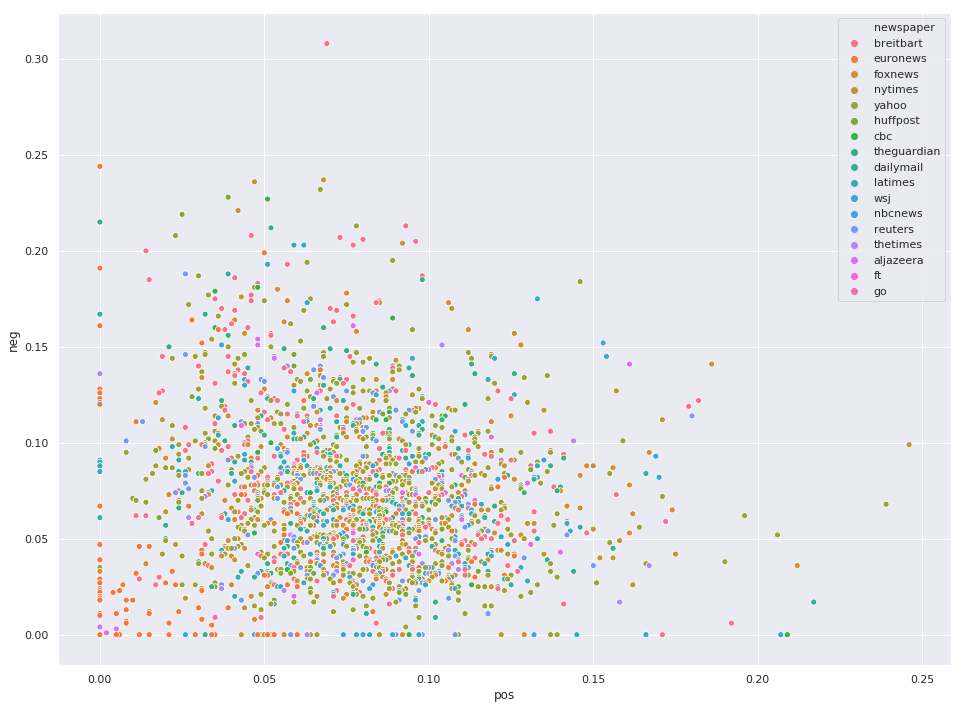

In [102]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(rc={'figure.figsize':(16,12)})
sns.scatterplot(data=articles_df, y="neg", x="pos", hue="newspaper")